# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [ ]:
pip install nltk -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install wordcloud==1.8.2.2 -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install Pillow==8.0.0 -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install scikit-learn==1.5.0 -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import wordcloud
import random


from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score

from wordcloud import WordCloud

RANDOM_STATE=42

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  как всегда на месте
</div>

## Подготовка

### Загрузка данных

In [ ]:
try:
    df = pd.read_csv('C:/Users/User/Desktop/Яндекс Практикум/toxic_comments.csv', index_col=0)
    print('local')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
    print('server')
df.head()

server


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
df.shape

(159292, 2)

### Проверка данных

In [ ]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [ ]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

**Вывод:** В данных большой дизбаланс классов, токсичых комментариев меньше (более чем в 10 раз).

### Подготовка данных к обучению

In [ ]:
corpus = df['text']#.values.astype('U')
target = df['toxic']
corpus[:2]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
Name: text, dtype: object

In [ ]:
corpus.shape

(159292,)

In [ ]:
def clear_text(corpus: np.array) -> np.array:
    """
    Очистить текст от всем символов кроме " '- ",
    Так как они могут иметь смысл в предложении
    """
    cl_corpus = []
    for i, text in enumerate(corpus):
        cl_txt = re.sub(r"[^a-zA-Z0-9]", ' ', text.lower())
        cl_corpus.append(" ".join(cl_txt.split()))
    return cl_corpus


assert clear_text(np.array(["Function: didn't test!!"])) == np.array(["function didn t test"])

In [ ]:
cl_corpus = clear_text(corpus)
cl_corpus[:2]

['explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now 89 205 38 27',
 'd aww he matches this background colour i m seemingly stuck with thanks talk 21 51 january 11 2016 utc']

In [ ]:
pd.DataFrame(cl_corpus).shape

(159292, 1)

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
#word_list = nltk.word_tokenize(cl_corpus[0])
#lemmatized_output = ' '.join([wnl.lemmatize(word) for word in word_list])
#lemmatized_output
#wnl.lemmatize(corpus[0])

In [ ]:
def get_wordnet_pos(tag):
    """
    Перевести тэги частей речи из "nltk.pos_tag"
    В "wordnet"
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
def lemmatize_text(text: list) -> list:
    """
    Лемматизировать текст, сначала используя токены,
    потом лемматизацию по частям речи
    """
    tokens = word_tokenize(text)
    pos_tag = nltk.pos_tag(tokens)
    lemmatized_words = []
    for token, tag in pos_tag:
        wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN
        lemmatized_word = wnl.lemmatize(token, pos=wordnet_pos)
        lemmatized_words.append(lemmatized_word)

    return ' '.join(lemmatized_words)

In [ ]:
lem_corpus = [lemmatize_text(sentence) for sentence in cl_corpus]
pd.DataFrame(lem_corpus[:5])

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(corpus[:3])

,text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."


In [ ]:
random.seed(10)
sample = ' '.join(random.choices(lem_corpus, k=10))
sample

"yes dominican republic-importance wikiproject african diaspora class start importance top no professor amar describe the incorporation of the 2a use future tense language clearly the incorporation have not happen yet accord to that preeminent expert on this topic fred newman i really see no need to threaten block my editingthe reason i have ask for a delineation of what be problematic viz blp be precisely so i could know which source to use or not use a threat seem a bit drasticas simple please find an alternate source would be sufficient and give the dozen of reference i have already add to what be a largely unsourced article i think it 's an unfair commentary on the good faith i have demonstrate thus far despite the constant hostility and personal attack etc from the demonstrably fanatical newmanophobes thank you user p00p could you take a look at there might not have be any positive pressure - that be the point of the first commenter 80 47 102 164 he be appoint a coordinator for if

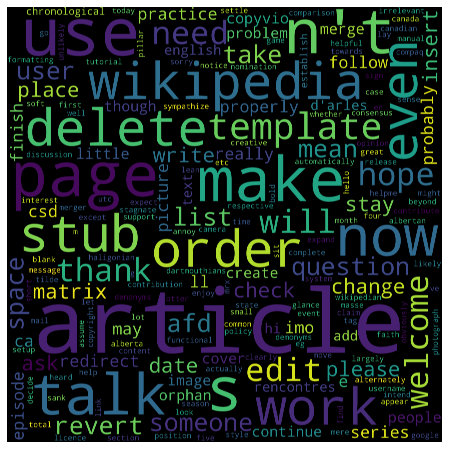

In [ ]:
wordcloud = WordCloud(
    width = 10000, height = 10000,
    random_state=RANDOM_STATE, collocations=False
).generate(sample)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Вывод:** Данные были очищены, токинезированы, и лемматизированны по частям речи.

**P.S.** В данных все-таки есть ошибки обработки, например - "do n't", боюсь, что это может влиять на оценку текста и финальную метрику.

## Обучение

In [ ]:
corpus.shape

(159292,)

In [ ]:
target.shape

(159292,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(lem_corpus, target, random_state=RANDOM_STATE, stratify=target)
pd.DataFrame(X_train).shape

(119469, 1)

In [ ]:
nlp_pipe = Pipeline(
    [
        ('tf_idf', TfidfVectorizer(stop_words=list(stop_words))), # Пытался добавить , метрика значительно упала
        ('models', MultinomialNB()) # Прочитал, что часто используют этц модель для текстов, но показывает она себя ужасно...
    ]
)

In [ ]:
nlp_pipe.fit(X_train, y_train)

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(stop_words=['ve', 'll', 'yours', 'out', 't',
                                             "you've", "hadn't", 'haven',
                                             'theirs', 'just', 'can', 'at',
                                             'no', 'this', 'what', 'as', 'only',
                                             'other', 'that', 'him',
                                             'themselves', 'shouldn', 'it',
                                             'once', 'didn', 'an', 'wasn',
                                             'between', 'more', 'in', ...])),
                ('models', MultinomialNB())])

In [ ]:
cross_val_score(nlp_pipe, X_train, y_train, scoring='f1').mean()

0.31861696257474853

**Вывод** Создан пайплайy в котром данные преобразуются в числа с помощью "TfidfVectorizer", после чего на них обучается модель. Как первичную модель я выбрал "MultinomialNB" (в пайплайне описал, почему ее выбрал).

Используя эту модель, метрика очень мала (32%)

### Поиск лучшей модели

In [ ]:
model_grid = [
    {
        'models': [ComplementNB()]  # Эта должна вроде лучше работать на несбалансированных данных
    },
    {
        'models': [LogisticRegression(solver='liblinear')],
        'models__penalty': ['l1', 'l2'],
        'models__class_weight': [{0:0.33, 1:0.67}, {0: 0.2, 1: 0.8}, {0: 0.4, 1: 0.6}],
        'models__C': [x / 10 for x in range(8, 20, 2)]
    },
    {
        'models': [SGDClassifier(random_state=RANDOM_STATE)],
        'models__loss': ['hinge', 'modified_huber', 'squared_hinge']
    }
]

In [ ]:
grid_search = GridSearchCV(
    nlp_pipe,
    model_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf_idf',
                                        TfidfVectorizer(stop_words=['ve', 'll',
                                                                    'yours',
                                                                    'out', 't',
                                                                    "you've",
                                                                    "hadn't",
                                                                    'haven',
                                                                    'theirs',
                                                                    'just',
                                                                    'can', 'at',
                                                                    'no',
                                                                    'this',
                                                                    'what',


In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(stop_words=['ve', 'll', 'yours', 'out', 't',
                                             "you've", "hadn't", 'haven',
                                             'theirs', 'just', 'can', 'at',
                                             'no', 'this', 'what', 'as', 'only',
                                             'other', 'that', 'him',
                                             'themselves', 'shouldn', 'it',
                                             'once', 'didn', 'an', 'wasn',
                                             'between', 'more', 'in', ...])),
                ('models',
                 LogisticRegression(C=1.8, class_weight={0: 0.33, 1: 0.67},
                                    penalty='l1', solver='liblinear'))])

In [ ]:
grid_search.best_score_

0.7810716455995123

In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False) # Теперь наивный байес и правда лучше работает

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__C,param_models__class_weight,param_models__penalty,param_models__loss,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
31,3.857290,0.047079,1.557122,0.026521,"LogisticRegression(C=1.8, class_weight={0: 0.3...",1.8,"{0: 0.33, 1: 0.67}",l1,NaN,"{'models': LogisticRegression(C=1.8, class_wei...",0.780744,0.782563,0.779907,0.781072,0.001109,1
25,3.792360,0.045317,1.564274,0.011501,"LogisticRegression(C=1.8, class_weight={0: 0.3...",1.6,"{0: 0.33, 1: 0.67}",l1,NaN,"{'models': LogisticRegression(C=1.8, class_wei...",0.778908,0.781336,0.777881,0.779375,0.001449,2
19,3.825576,0.026265,1.570505,0.028935,"LogisticRegression(C=1.8, class_weight={0: 0.3...",1.4,"{0: 0.33, 1: 0.67}",l1,NaN,"{'models': LogisticRegression(C=1.8, class_wei...",0.777231,0.779796,0.775608,0.777545,0.001724,3
35,3.901930,0.041196,1.604419,0.029001,"LogisticRegression(C=1.8, class_weight={0: 0.3...",1.8,"{0: 0.4, 1: 0.6}",l1,NaN,"{'models': LogisticRegression(C=1.8, class_wei...",0.776115,0.779519,0.773330,0.776321,0.002531,4
33,3.929312,0.036469,1.566800,0.015848,"LogisticRegression(C=1.8, class_weight={0: 0.3...",1.8,"{0: 0.2, 1: 0.8}",l1,NaN,"{'models': LogisticRegression(C=1.8, class_wei...",0.774812,0.779390,0.774367,0.776190,0.002270,5
27,3.802151,0.014658,1.570457,0.027210,"LogisticRegression(C=1.8, class_weight={0: 0.3...",1.6,"{0: 0.2, 1: 0.8}",l1,NaN,"{'models': LogisticRegression(C=1.8, class_wei...",0.775177,0.777643,0.772783,0.775201,0.001984,6
13,3.792101,0.036143,1.548835,0.017342,"LogisticRegression(C=1.8, class_weight={0: 0.3...",1.2,"{0: 0.33, 1: 0.67}",l1,NaN,"{'models': LogisticRegression(C=1.8, class_wei...",0.775680,0.777481,0.770701,0.774621,0.002867,7
29,3.807705,0.024627,1.542596,0.036491,"LogisticRegression(C=1.8, class_weight={0: 0.3...",1.6,"{0: 0.4, 1: 0.6}",l1,NaN,"{'models': LogisticRegression(C=1.8, class_wei...",0.773435,0.776148,0.771280,0.773621,0.001992,8
21,3.833446,0.027956,1.552983,0.043825,"LogisticRegression(C=1.8, class_weight={0: 0.3...",1.4,"{0: 0.2, 1: 0.8}",l1,NaN,"{'models': LogisticRegression(C=1.8, class_wei...",0.774170,0.775795,0.770767,0.773577,0.002095,9
15,3.829568,0.009327,1.568679,0.010256,"LogisticRegression(C=1.8, class_weight={0: 0.3...",1.2,"{0: 0.2, 1: 0.8}",l1,NaN,"{'models': LogisticRegression(C=1.8, class_wei...",0.770880,0.773559,0.771471,0.771970,0.001150,10


**Вывод** После подбора моделей и их параметров по сетке метрика значительно улучшилась (78% на кросс валидации)

Лучшая модель - Логистическая Регрессия с 'liblinear' ядром.

## Предсказания на тестовой выборке

In [ ]:
preds = grid_search.best_estimator_.predict(X_test)

In [ ]:
f1_score(y_test, preds)

0.7850320554755985

**Вывод:** На тестовой выборке модель показывает метрику не ниже поставленной в задаче - успех)

**P.S.** Потом хотел бы попробовать БЕРТ

## Выводы

В течение работы были обработаны и подготовлены данные для обучения моделей классификации тональности текста. Были применены торкенизация, лемматизация и TF-IDF для текстов.

Были обучены несколько моделей машинного обучения, они были подобраны так, что справиться с дисбалансом классов в данных. Наилучшим образом себя показала модель линейной регресии с весами классов: {0: 0.33, 1: 0.67}. Ее метрика на тестовых данных - 78.5%.